In [119]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os

In [120]:

# Hyperparameters
lookback_window = 7  # Number of time steps
#I don't have any idea which number is best
# from past test it looks like model has an understanding of general trend of the stock
# but not the specific chracteristics of the stock
# chatgpt recommends me to increase lookback window
input_size = 7       # Number of features (univariate = 1)
output_size = 1       # Predicting one value
hidden_size = 64      # Number of LSTM neurons
num_layers = 2        # Number of LSTM layers

alpha=1 #weight of directional loss
learning_rate = 0.001
epochs = 10
batch_size = 32

#TODO: USD/TRY exchange rate input
#TODO: Faiz Enflasyon ve Piyasa Katılımcıları Anketi input

#TODO: Takas Verisi (model iyi sonuçlar vermezse son çare olarak kullanılabilir)

#TODO: Vadeli İşlem ve Opsiyon Borsası (VIOP) input (Çok karmaşıklaştırıyor gelecekte belki)
#TODO: Anlık Aracı Kurum Dağılımı  (çok karıştırabilir)



In [121]:
dataLocation="../Data/StandardizedData"
allcsvs=os.listdir(dataLocation)
# turn float64 to float 32

In [122]:
unnecessaryColumns=["Date"]

from Scaler import Scaler
from sklearn.preprocessing import StandardScaler


# Can't do with minMax scaler we need Z scaler
#Rewrite Time
scaler = Scaler(0,50)
zScalerDic={}


def df_to_X_y(df,zScaler,window_size=6):
  lightWeightDf=df.drop(columns=unnecessaryColumns)
  df_as_np = zScaler.fit_transform(lightWeightDf.to_numpy())
  # df_as_np = lightWeightDf.to_numpy()
  
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i + window_size]]
    X.append(row)
    label = df_as_np[i + window_size, -1]
    y.append(label)
  return np.array(X), np.array(y)
#df_to_X_y(pd.read_csv(dataLocation+"/AEFES.IS.csv"),scaler,lookback_window)

In [123]:
# Combine all CSVs
def process_all_data():
    XAll = []
    yAll = []
    nameAll = []

    for csv_file in allcsvs:
        rawData = pd.read_csv(os.path.join(dataLocation, csv_file))
        currentScaler = StandardScaler()
        zScalerDic[csv_file] = currentScaler

        Xtemp, yTemp = df_to_X_y(rawData, currentScaler, lookback_window)
        XAll.append(Xtemp)
        yAll.append(yTemp)
        nameAll.extend([csv_file] * len(yTemp))

    XAll = np.concatenate(XAll, axis=0)
    yAll = np.concatenate(yAll, axis=0)

    return XAll, yAll, np.array(nameAll)

XAll, yAll, nameAll = process_all_data()

# %%

# I have to store all of the rawData accurately because I need them afterwards
# or I can make a huge tensor and store all of them in it
# but this raises concerns about the time series consistency

In [124]:
XAll.shape, yAll.shape, nameAll.shape

((57412, 7, 7), (57412,), (57412,))

In [125]:
def shuffle_data(X, y, names):
    """
    Shuffle the data while maintaining the correspondence between X and y.

    Parameters:
    X (numpy.ndarray): The input features tensor.
    y (numpy.ndarray): The target array.

    Returns:
    tuple: Shuffled X and y tensors.
    """
    assert len(X) == len(y), "X and y must have the same length."
    assert len(y) == len(names), "y and names must have the same length."

    # Generate a random permutation of indices
    #TODO add a seed for reproducibility
    #add seed to the code below
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    # print(indices[:5])
    # Shuffle X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    name_shuffled = names[indices]
    
    return X_shuffled, y_shuffled, name_shuffled

In [126]:
X_shuffled, y_shuffled, name_shuffled = shuffle_data(XAll, yAll, nameAll)

In [127]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, names):
        self.dataX = torch.tensor(X, dtype=torch.float32)
        self.dataY = torch.tensor(y, dtype=torch.float32)
        self.names = names

    def __len__(self):
        return self.dataX.size(0)

    def __getitem__(self, idx):
        sequence = self.dataX[idx, :]
        target = self.dataY[idx]
        name = self.names[idx]
        return sequence, target, name

# %%


#TODO  dropout or batch normalization
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [128]:
import torch.nn.functional as F


#TODO test and utilize
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, lstm_outputs):
        # lstm_outputs: [batch_size, seq_len, hidden_dim]
        attention_scores = self.attention_weights(lstm_outputs).squeeze(-1)  # [batch_size, seq_len]
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, seq_len]
        weighted_output = torch.sum(lstm_outputs * attention_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_dim]
        return weighted_output, attention_weights
    

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False):
        super(LSTMAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = AttentionMechanism(hidden_dim * (2 if bidirectional else 1))
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim]
        attention_out, attention_weights = self.attention(lstm_out)  # [batch_size, hidden_dim], [batch_size, seq_len]
        output = self.fc(attention_out)  # [batch_size, output_dim]
        return output, attention_weights

In [129]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

Using cuda


In [130]:
X_train, y_train = X_shuffled[:int(0.8 * len(X_shuffled))], y_shuffled[:int(0.8 * len(y_shuffled))]
X_val, y_val = X_shuffled[int(0.8 * len(X_shuffled)):], y_shuffled[int(0.8 * len(y_shuffled))]
name_train, name_val = name_shuffled[:int(0.8 * len(name_shuffled))], name_shuffled[int(0.8 * len(name_shuffled))]


X_val = X_shuffled[int(0.8*len(X_shuffled)):]
y_val = y_shuffled[int(0.8*len(y_shuffled)):]
name_val = name_shuffled[int(0.8*len(name_shuffled)):]

In [131]:
trainDataset = TimeSeriesDataset(X_train, y_train,name_train)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=False)
#Dataset for validation
valDataset = TimeSeriesDataset(X_val, y_val,name_val)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

# Cross-validation: On non-overlapping sequential splits for evaluation.

In [132]:
def directional_loss(outputs, targets, sequences):
    # Calculate the direction of predictions and actual values
    pred_dir = outputs.squeeze()  >= 0
    true_dir = targets  >= 0
    # Penalize mismatched directions
    mismatches = (pred_dir != true_dir).float()
    return mismatches.mean()

In [133]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for sequences, targets in dataloader:
        sequences, targets = sequences.to(device), targets.to(device)
        print(f"Train - Sequences device: {sequences.device}, Targets device: {targets.device}")

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)
    


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for sequences, targets in dataloader:
            sequences, targets = sequences.to(device), targets.to(device)
            print(f"Validate - Sequences device: {sequences.device}, Targets device: {targets.device}")

            outputs = model(sequences)
            loss = criterion(outputs, targets)

            running_loss += loss.item()

    return running_loss / len(dataloader)


## Some Potenetial Metrics to evaluate models

Profit and Loss (PnL) simulation for trading applications.

In [134]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [135]:

valLosses=[]
trainLosses=[]
DAvals=[]
# Training loop
for epoch in range(epochs):

    epoch_loss=train_one_epoch(model,optimizer,criterion,train_loader)
    val_loss, direction=validate(model,criterion,val_loader)
    valLosses.append(val_loss)
    trainLosses.append(epoch_loss)
    DAvals.append(direction)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}, Directional Accuracy: {direction / len(nameAll):.4f}")

TypeError: train_one_epoch() missing 1 required positional argument: 'device'

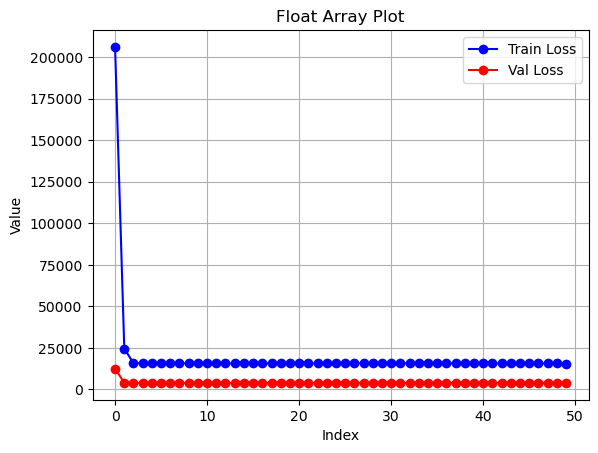

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
startPoint=0
# Example float array
val_array = valLosses[startPoint:]
train_array = trainLosses[startPoint:]

# Create an x-axis for the data points
x = np.arange(len(train_array))
y = np.arange(len(val_array))

# Plot the graph
plt.plot(x, train_array, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(y, val_array, marker='o', linestyle='-', color='r', label='Val Loss')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Float Array Plot')
plt.legend()

plt.grid(True)
plt.show()

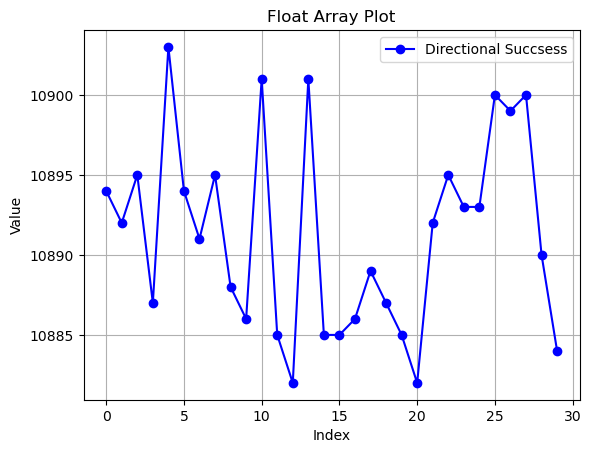

In [ ]:
startPoint=20
da_array = DAvals[startPoint:]
# Create an x-axis for the data points
x = np.arange(len(da_array))

# Plot the graph
plt.plot(x, da_array, marker='o', linestyle='-', color='b', label='Directional Succsess')
# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Float Array Plot')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
# Extract one batch of data for testing
model.to(device)
for sequences, targets, name in train_loader:
    testInput = sequences.to(device)  # Sequence data
    # testInput.to(device)
    print(f"Test Input Shape: {testInput.shape}")
    realOutput = targets   # Ground truth output
    break

# Ensure the model is in evaluation mode
model.eval()

# Predict using the model
with torch.no_grad():  # Disable gradient calculations for inference
    predicted = model(testInput).squeeze()  # Forward pass through the model

# Check shapes and results
print(f"Predicted Output Shape: {predicted.shape}")
print(f"First Prediction: {predicted[0].item()}")
print(f"Actual Output (First Target): {realOutput[0].item()}")

predicted
# testInput.shape

Test Input Shape: torch.Size([32, 7, 7])
Predicted Output Shape: torch.Size([32])
First Prediction: 22.024295806884766
Actual Output (First Target): 24.29424476623535


tensor([22.0243, 22.0228, 21.9584, 22.0228, 22.0229, 22.0255, 22.0229, 22.0229,
        22.0229, 22.0230, 21.7241, 22.0229, 22.0229, 22.0229, 22.0230, 20.9263,
        22.0228, 21.8627, 22.0235, 20.9506, 21.9365, 22.0234, 22.0238, 21.6591,
        22.0228, 22.0229, 22.0229, 22.0235, 22.0266, 22.0231, 22.0227, 22.0229],
       device='cuda:0')

In [67]:
realOutput

tensor([24.2942, 21.6720, 17.8864, 16.9488, 21.6909, 21.1853, 18.9113, 19.3737,
        21.6331, 21.9316, 19.4545, 20.6627, 21.4087, 21.8962, 20.7968, 23.6905,
        21.3292, 19.5903, 18.2252, 22.1843, 20.1580, 23.0305, 23.7830, 25.9998,
        19.0670, 25.0667, 17.9985, 21.3697, 24.4653, 22.1478, 21.9370, 22.4500])